In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

# Load dataset: Choose MNIST or EMNIST
def load_data(dataset='mnist'):
    if dataset.lower() == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        num_classes = 10
    elif dataset.lower() == 'emnist':
        import tensorflow_datasets as tfds
        ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)
        ds_train = ds_train.map(lambda img, label: (tf.cast(img, tf.float32), label))
        ds_test = ds_test.map(lambda img, label: (tf.cast(img, tf.float32), label))
        x_train, y_train = zip(*[(img.numpy(), label.numpy()) for img, label in tfds.as_numpy(ds_train)])
        x_test, y_test = zip(*[(img.numpy(), label.numpy()) for img, label in tfds.as_numpy(ds_test)])
        x_train, x_test = np.array(x_train), np.array(x_test)
        y_train, y_test = np.array(y_train), np.array(y_test)
        num_classes = 26  # EMNIST Letters: A-Z
    else:
        raise ValueError("Dataset must be 'mnist' or 'emnist'.")

    # Preprocess data
    x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1) / 255.0
    y_train = tf.keras.utils.to_categorical(y_train - 1 if dataset == 'emnist' else y_train, num_classes)
    y_test_cat = tf.keras.utils.to_categorical(y_test - 1 if dataset == 'emnist' else y_test, num_classes)
    
    return x_train, y_train, x_test, y_test, y_test_cat, num_classes

# Build CNN model
def build_model(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate
def train_and_evaluate(dataset='mnist', epochs=5, batch_size=64):
    x_train, y_train, x_test, y_test, y_test_cat, num_classes = load_data(dataset)
    model = build_model(num_classes)
    model.summary()
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    test_loss, test_acc = model.evaluate(x_test, y_test_cat)
    print(f"\n✅ Test Accuracy: {test_acc:.4f}")

    # Predict and evaluate
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = y_test - 1 if dataset == 'emnist' else y_test
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))

    return model

# Run the pipeline
if __name__ == "__main__":
    model = train_and_evaluate(dataset='mnist', epochs=10)  # switch to 'mnist' for digits


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

1/1 [==============================] - 0s 396ms/step


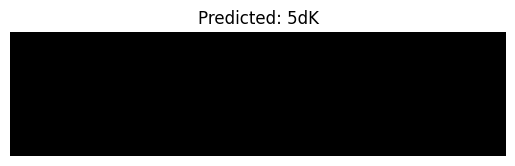

Predicted Text: 5dK


In [5]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Character mappings
char_list = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 "
char_to_num = {char: idx for idx, char in enumerate(char_list)}
num_to_char = {idx: char for char, idx in char_to_num.items()}

# Preprocessing
def preprocess_image(image, img_width=128, img_height=32):
    image = cv2.resize(image, (img_width, img_height))
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

# Decode prediction
def decode_prediction(pred):
    decoded = tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1])[0][0]
    return ["".join([num_to_char[i] for i in seq if i != -1]) for seq in decoded.numpy()]

# Build CRNN model
def build_crnn(img_width=128, img_height=32, num_classes=len(char_list)):
    input_img = layers.Input(shape=(img_height, img_width, 1), name='image')
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    new_shape = (img_width // 4, (img_height // 4) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dense(num_classes + 1, activation='softmax')(x)
    model = models.Model(inputs=input_img, outputs=x)
    return model

# Dummy test
def test_crnn_model():
    model = build_crnn()
    dummy_image = np.ones((32, 128), dtype=np.uint8) * 255  # blank white image
    processed_image = preprocess_image(dummy_image)
    processed_image = np.expand_dims(processed_image, axis=0)
    dummy_prediction = model.predict(processed_image)
    decoded_text = decode_prediction(dummy_prediction)
    plt.imshow(dummy_image, cmap='gray')
    plt.title(f"Predicted: {decoded_text[0]}")
    plt.axis('off')
    plt.show()
    return decoded_text[0]

# Run test
print("Predicted Text:", test_crnn_model())
